In [1]:
# Import necessary libraries for text data preprocessing
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import re
import nltk
nltk.data.path.append('/path/to/your/nltk_data')  # adjust this path
from nltk.corpus import stopwords
stopwords.words('english') # Common stopwords

import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import plotly.figure_factory as ff
from plotly.subplots import make_subplots

from wordcloud import WordCloud
from gensim.models import Word2Vec

from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.utils import pad_sequences
from keras.utils import to_categorical

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Flatten, Dropout, Embedding, GlobalMaxPooling1D, Conv1D, SimpleRNN, LSTM, GRU, Bidirectional


import warnings
warnings.filterwarnings('ignore')


import spacy
nlp = spacy.load('en_core_web_sm')
from tqdm import tqdm
from nltk.corpus import stopwords
# Do#wnloading necessary resources for NLTK
nltk.data.path.append('/your/local/path/to/nltk_data')
from nltk.tokenize import word_tokenize,sent_tokenize# Tokenization tool
#nltk.download('punkt')  # Tokenization tool
#nltk.download('stopwords')  # Common stopwords

# Defining and refining the set of English stopwords
stop_words = set(stopwords.words('english'))
# Removing some stopwords that may carry important sentiment or meaning
stop_words = [i for i in stop_words if i not in ['not','until','against','up', 'down', 'no', 'nor',"aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',
                                                "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn', "mustn't", 'needn', "needn't", 
                                                 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't", "don't"]]



2025-04-15 18:38:44.997339: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744742325.024104     712 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744742325.032587     712 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


1. EXPLORATORY DATA ANALYSIS

1.1  DATA LOADING

In [2]:
# Reading a CSV file containing sentiment data, skipping bad lines
df=pd.read_csv('/kaggle/input/sentiment140/training.1600000.processed.noemoticon.csv',encoding='latin',header=None,on_bad_lines='skip')
df.head()
# Renaming columns for better clarity
df.rename(columns={0: 'labels', 5: 'tweets'}, inplace=True)

# Dropping unnecessary columns from the DataFrame
df.drop([1, 2, 3, 4], axis=1, inplace=True)

# Replacing label 4 (positive sentiment) with 1 for uniformity
df['labels'] = df['labels'].replace(4, 1)

# Randomly shuffling the DataFrame and selecting a subset of 10,000 rows
df = df.sample(frac=1)
df = df.head(10000)

# Displaying the first few rows of the DataFrame
df.head()

,labels,tweets
692275,0,Im bored n feel shit
147459,0,@cloverdash He's playing Juan Ignacio Chela......
1174971,1,"If anyone wants to spend their money, I would ..."
384786,0,http://twitpic.com/6qk3n - Muishui for @fonzar...
809307,1,Wheat Thins and Diet Dr. Pepper = breakfast of...


1.2  DATA CLEANING

In [3]:
# Function to get the number of words in a tweet
def get_word_len(tweet):
    return len(tweet.split(' '))

# Function to get the number of characters in a tweet
def get_char_len(tweet):
    return len(tweet)

# Function to preprocess a tweet
def preprocess_tweet(tweet):
    # Convert the tweet to lowercase
    tweet = tweet.lower()
    
    # Remove URLs from the tweet
    tweet = re.sub(r"http\S+|www\S+|https\S+", '', tweet, flags=re.MULTILINE)
    
    # Remove mentions (e.g., @username) from the tweet
    tweet = re.sub(r'@\w+', '', tweet)
    
    # Remove special characters and punctuation from the tweet
    tweet = re.sub(r'[^\w\s#]', '', tweet)
    
    # Lemmatize the words using spaCy
    tokens = [token.lemma_ for token in nlp(tweet)]
    
    # Remove stop words
    tokens = [token for token in tokens if token not in stop_words]
    
    # Remove single-character tokens
    tokens = [token for token in tokens if len(token) > 1]
    
    # Join the processed tokens to form the cleaned tweet
    processed_tweet = ' '.join(tokens)
    
    return processed_tweet

# Apply the preprocess_tweet function to each tweet in the dataframe
df['clean_tweets'] = [preprocess_tweet(tw) for tw in tqdm(df['tweets'], position=0, leave=True)]

# Calculate the number of words in each cleaned tweet and store it in a new column
df['tweet_words_length'] = df['clean_tweets'].apply(get_word_len)

# Calculate the number of characters in each cleaned tweet and store it in a new column
df['tweet_chars_length'] = df['clean_tweets'].apply(get_char_len)

# Display the first few rows of the dataframe
df.head()

100%|██████████| 10000/10000 [01:12<00:00, 137.33it/s]


,labels,tweets,clean_tweets,tweet_words_length,tweet_chars_length
692275,0,Im bored n feel shit,bored feel shit,3,15
147459,0,@cloverdash He's playing Juan Ignacio Chela......,play juan ignacio chelawhos good clay annoying...,10,66
1174971,1,"If anyone wants to spend their money, I would ...",anyone want spend money would love wii,7,38
384786,0,http://twitpic.com/6qk3n - Muishui for @fonzar...,muishui beautifuldontknow anyone could dump,8,46
809307,1,Wheat Thins and Diet Dr. Pepper = breakfast of...,wheat thin diet dr pepper breakfast championso...,14,88


1.3   CREATING LABEL DISTRIBUTION

In [4]:
# Count the number of positive and negative tweets in the dataframe
positive_count = df[df['labels'] == 1].shape[0]
negative_count = df[df['labels'] == 0].shape[0]

# Create a pie chart using Plotly Express to visualize the distribution of positive and negative tweets
fig = px.pie(
    values=[positive_count, negative_count],  # Values represent the counts of positive and negative tweets
    title='Distribution of Positive and Negative Tweets',  # Title of the pie chart
    names=['Positive', 'Negative'],  # Labels for the two categories
    hover_name=['Positive', 'Negative'],  # Hover information for each category
    opacity=.9,  # Opacity of the pie chart
    template='simple_white'  # Plotly template for the chart
)

# Display the pie chart
fig.show()

1.4  CREATING WORD CLOUD

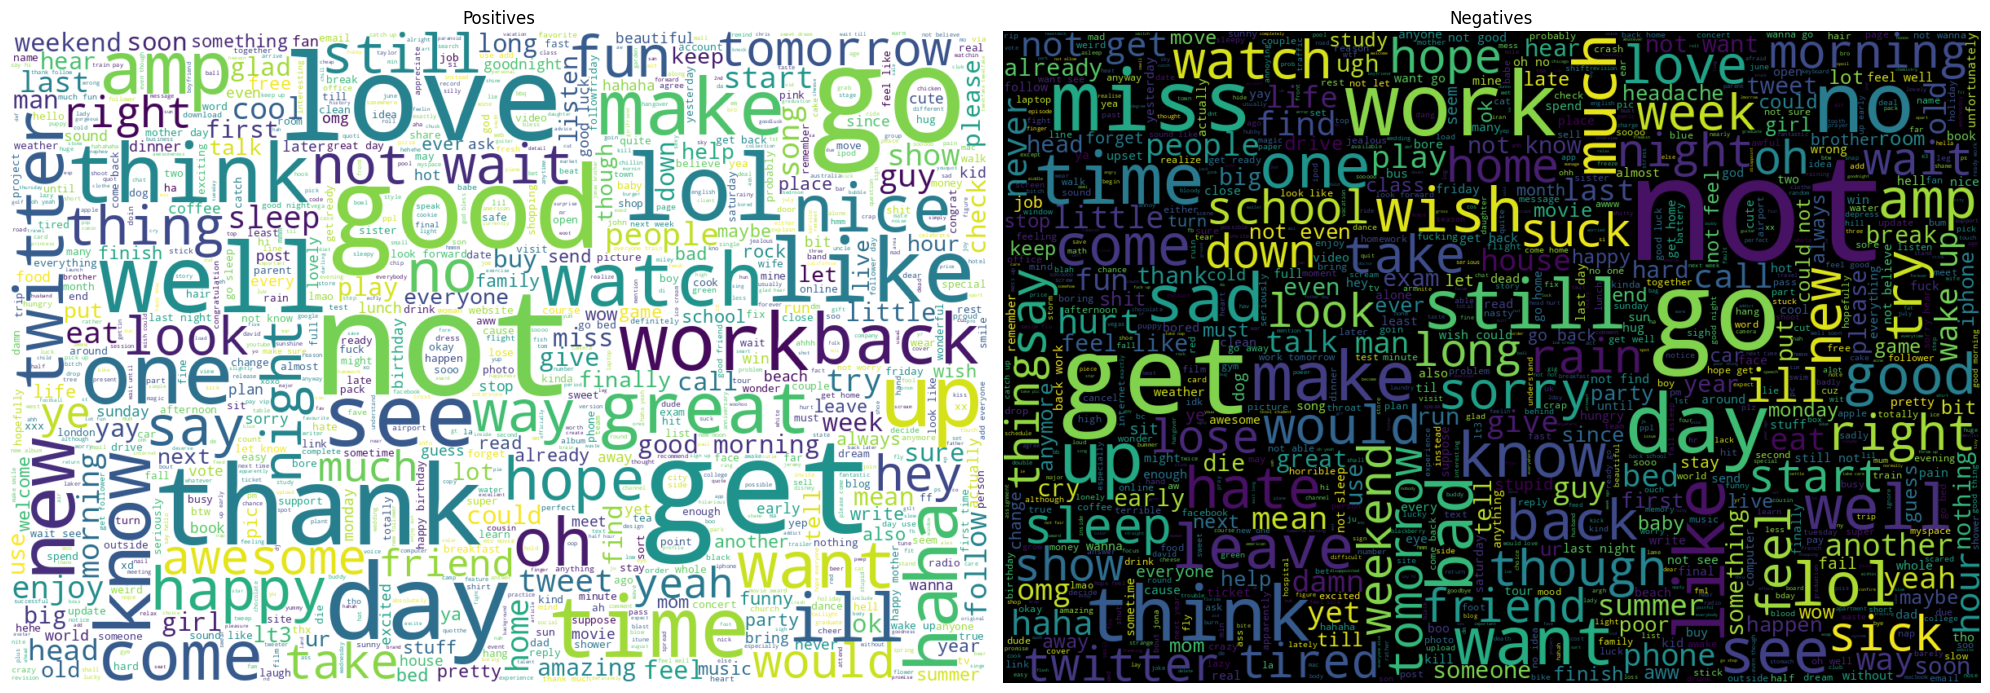

In [5]:
# Set up a figure with a specified size
plt.figure(figsize=(20, 8))

# Define stopwords for WordCloud (common words to exclude)
STOPWORDS = ['im','today','really','need','tonight']

# Plot two subplots side by side
plt.subplot(1, 2, 1)

# Generate and display a WordCloud for positive tweets
wordcloud_1 = WordCloud(
    width=1200, height=800, max_words=1000, contour_width=2,
    background_color='white', stopwords=STOPWORDS, max_font_size=180,
    colormap='viridis'
).generate(' '.join(df[df['labels'] == 1]['clean_tweets']))

plt.imshow(wordcloud_1, interpolation='bilinear')
plt.axis('off')
plt.title('Positives')

# Plot the second subplot
plt.subplot(1, 2, 2)

# Generate and display a WordCloud for negative tweets
wordcloud_2 = WordCloud(
    width=1200, height=800, max_words=1000, contour_width=2,
    background_color='black', stopwords=STOPWORDS, max_font_size=180,
    colormap='viridis'
).generate(' '.join(df[df['labels'] == 0]['clean_tweets']))

plt.imshow(wordcloud_2, interpolation='bilinear')
plt.axis('off')
plt.title('Negatives')

# Turn off axis for the entire plot
plt.axis('off')

# Adjust layout for better spacing
plt.tight_layout()

# Display the plot
plt.show()

1.5  CREATING WORD LENGTH DISTRIBUTION

In [6]:
# Create distribution plots for word count and character count for positive and negative tweets
fig_words = ff.create_distplot(
    [df[df['labels'] == 1]['tweet_words_length'], df[df['labels'] == 0]['tweet_words_length']],
    ['Positive', 'Negative'],
    bin_size=25,
    show_hist=False,
    show_rug=False
)

fig_chars = ff.create_distplot(
    [df[df['labels'] == 1]['tweet_chars_length'], df[df['labels'] == 0]['tweet_chars_length']],
    ['Positive', 'Negative'],
    bin_size=25,
    show_hist=False,
    show_rug=False
)

# Set titles and labels for the distribution plots
fig_chars.update_layout(title="Distribution Plot on Character Count", xaxis_title="Number of Characters", yaxis_title="Frequency")
fig_words.update_layout(title="Distribution Plot on Word Count", xaxis_title="Number of Words", yaxis_title="Frequency")

# Combine the plots in a 2-column layout
fig = make_subplots(rows=1, cols=2, subplot_titles=["Word Count", "Character Count"])
fig.add_trace(fig_words['data'][0], row=1, col=1)
fig.add_trace(fig_words['data'][1], row=1, col=1)
fig.add_trace(fig_chars['data'][0], row=1, col=2)
fig.add_trace(fig_chars['data'][1], row=1, col=2)

# Update overall layout and show the plot
fig.update_layout(title_text="Distribution Plots - Word Count vs Character Count", showlegend=True, font=dict(family="Arial", size=15, color="black"))
fig.show()

2) Data Preparation for Model Building

2.1) Loading the Dataset

In [18]:
df = pd.read_csv('/kaggle/input/sentiment140/training.1600000.processed.noemoticon.csv', encoding = "latin", header = None, on_bad_lines='skip')

df.rename(columns={0: 'labels', 5: 'tweets'}, inplace=True)
df.drop([1,2,3,4], axis=1, inplace = True)

df['labels'] = df['labels'].replace(4,1)

df = df.sample(frac=1)
df = df.head(10000)

2.2) Data Cleaning

In [8]:
df['clean_tweets'] = [preprocess_tweet(tw) for tw in tqdm(df['tweets'] ,position=0, leave=True )]
df['tweet_words_length'] = df['clean_tweets'].apply(get_word_len)
df['tweet_chars_length'] = df['clean_tweets'].apply(get_char_len)

df.head()

100%|██████████| 10000/10000 [01:11<00:00, 139.69it/s]


,labels,tweets,clean_tweets,tweet_words_length,tweet_chars_length
1048339,1,1 2 3 4 - Plain White T's Just love this song,plain white ts love song,8,27
1568097,1,@pinksage phoenixwolf27@hotmail.com.,phoenixwolf27com,1,16
888123,1,This is another time,another time,2,12
943948,1,http://twitpic.com/55igj - @sammyandres just s...,stop drop apparently good friend,9,36
1405617,1,@DobieLuver I'll let you know if I find extra ...,ill let know find extra horsie enjoy up,12,43


3) Trying different Neural Networks

3.1) Splitting Dataset into Training/Testing and Validation

In [9]:
# Splitting the dataset into training and testing sets with an 80-20 split
x_train, x_test, y_train, y_test = train_test_split(df['clean_tweets'], df['labels'], test_size=0.2, random_state=42)

# Further splitting the test set into validation and final test sets with a 50-50 split
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=0.5)

# Creating a pie chart to visualize the distribution of tweet counts in training, testing, and validation sets
fig = px.pie(values=[len(x_train), len(x_test), len(x_val)], title='Distribution of Training, Testing, and Validation Tweets', 
             names=['Training', 'Testing', 'Validation'], hover_name=['Training', 'Testing', 'Validation'], opacity=0.9, template='simple_white')

# Displaying the pie chart
fig.show()

3.2) One Hot Encoded + Model Training

In [10]:
# Setting up parameters for neural network training
epochs_ = 10            # Number of training epochs
seq_len = 20            # Length of input sequences
batch_size_ = 64        # Batch size for training
training_size = .8      # Percentage of data used for training
embedding_len = 100     # Length of word embeddings

# Using CountVectorizer with binary encoding for tweets
vec = CountVectorizer(binary=True)
vec = vec.fit(df['clean_tweets'])

# Transforming and converting tweets into arrays
enc_tweets = vec.transform(df['clean_tweets']).toarray()

# Splitting the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(enc_tweets, df['labels'], test_size=training_size, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=0.5)

# Building a neural network model with multiple dense layers and dropout for regularization
model = Sequential()
model.add(Dense(2048, activation='relu', input_shape=(enc_tweets.shape[1],)))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

# Compiling the model using binary crossentropy loss and Adam optimizer with a specified learning rate
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])

# Training the model and storing the training history
history_1 = model.fit(x_train, y_train, epochs=epochs_, batch_size=batch_size_, validation_data=(x_val, y_val))

# Evaluating and printing the model's accuracy on the testing data
print('\n')
print("Model Evaluation on Testing Data: ", round(model.evaluate(x_test, y_test)[1] * 100, 2))

2025-04-15 18:41:45.404297: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Epoch 1/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 17s 437ms/step - accuracy: 0.4791 - loss: 0.6950 - val_accuracy: 0.5512 - val_loss: 0.6911
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 19s 395ms/step - accuracy: 0.5287 - loss: 0.6877 - val_accuracy: 0.5165 - val_loss: 0.6869
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 409ms/step - accuracy: 0.5719 - loss: 0.6766 - val_accuracy: 0.6110 - val_loss: 0.6765
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 390ms/step - accuracy: 0.6345 - loss: 0.6438 - val_accuracy: 0.6467 - val_loss: 0.6535
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 409ms/step - accuracy: 0.7453 - loss: 0.5919 - val_accuracy: 0.6888 - val_loss: 0.6209
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 394ms/step - accuracy: 0.8525 - loss: 0.4744 - val_accuracy: 0.7082 - val_loss: 0.5884
Epoch 7/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 392ms/step - accuracy: 0.9229 - loss: 0.3552 - val_accuracy: 0.7065 - val_loss: 0.6174
Epoch 8/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 392ms/step - accuracy: 0.9516 - loss: 0.2363 - val_accu

3.3) Count Vectorizer + Model Training

In [11]:
# Using CountVectorizer without binary encoding for tweets
vec = CountVectorizer(binary=False)
vec = vec.fit(df['clean_tweets'])

# Transforming and converting tweets into arrays
enc_tweets = vec.transform(df['clean_tweets']).toarray()

# Splitting the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(enc_tweets, df['labels'], test_size=training_size, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=0.5)

# Building a neural network model with multiple dense layers and dropout for regularization
model = Sequential()
model.add(Dense(2048, activation='relu', input_shape=(enc_tweets.shape[1],)))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

# Compiling the model using binary crossentropy loss and Adam optimizer with a specified learning rate
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])

# Training the model and storing the training history
history_2 = model.fit(x_train, y_train, epochs=epochs_, batch_size=batch_size_, validation_data=(x_val, y_val))

# Evaluating and printing the model's accuracy on the testing data
print('\n')
print("Model Evaluation on Testing Data: ", round(model.evaluate(x_test, y_test)[1] * 100, 2))

Epoch 1/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 19s 507ms/step - accuracy: 0.5241 - loss: 0.6890 - val_accuracy: 0.5100 - val_loss: 0.6890
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 398ms/step - accuracy: 0.5351 - loss: 0.6817 - val_accuracy: 0.5527 - val_loss: 0.6832
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 393ms/step - accuracy: 0.5597 - loss: 0.6730 - val_accuracy: 0.5748 - val_loss: 0.6737
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 407ms/step - accuracy: 0.6279 - loss: 0.6470 - val_accuracy: 0.6497 - val_loss: 0.6551
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 12s 391ms/step - accuracy: 0.7287 - loss: 0.5996 - val_accuracy: 0.6812 - val_loss: 0.6287
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 15s 484ms/step - accuracy: 0.8185 - loss: 0.5174 - val_accuracy: 0.6923 - val_loss: 0.6028
Epoch 7/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 400ms/step - accuracy: 0.8846 - loss: 0.4091 - val_accuracy: 0.6955 - val_loss: 0.5966
Epoch 8/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 394ms/step - accuracy: 0.9139 - loss: 0.3025 - val_accu

3.4) TF-IDF + Model Training

In [12]:
# Using TF-IDF vectorization for tweets
tfidf = TfidfVectorizer()
enc_tweets = tfidf.fit_transform(df['clean_tweets']).toarray()

# Splitting the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(enc_tweets, df['labels'], test_size=training_size, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=0.5)

# Building a neural network model with multiple dense layers and dropout for regularization
model = Sequential()
model.add(Dense(2048, activation='relu', input_shape=(enc_tweets.shape[1],)))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

# Compiling the model using binary crossentropy loss and Adam optimizer with a specified learning rate
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])

# Training the model and storing the training history
history_3 = model.fit(x_train, y_train, epochs=epochs_, batch_size=batch_size_, validation_data=(x_val, y_val))

# Evaluating and printing the model's accuracy on the testing data
print('\n')
print("Model Evaluation on Testing Data: ", round(model.evaluate(x_test, y_test)[1] * 100, 2))

Epoch 1/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 16s 410ms/step - accuracy: 0.5192 - loss: 0.6930 - val_accuracy: 0.5128 - val_loss: 0.6928
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 12s 387ms/step - accuracy: 0.5161 - loss: 0.6922 - val_accuracy: 0.5915 - val_loss: 0.6920
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 402ms/step - accuracy: 0.6010 - loss: 0.6895 - val_accuracy: 0.6507 - val_loss: 0.6901
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 386ms/step - accuracy: 0.6336 - loss: 0.6841 - val_accuracy: 0.6758 - val_loss: 0.6842
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 386ms/step - accuracy: 0.7279 - loss: 0.6678 - val_accuracy: 0.6867 - val_loss: 0.6683
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 12s 385ms/step - accuracy: 0.8268 - loss: 0.6161 - val_accuracy: 0.6965 - val_loss: 0.6270
Epoch 7/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 409ms/step - accuracy: 0.9088 - loss: 0.4906 - val_accuracy: 0.6957 - val_loss: 0.5804
Epoch 8/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 12s 388ms/step - accuracy: 0.9370 - loss: 0.3029 - val_accu

3.5) ANN with Text Sequencess

3.5.1) Loading the Dataset

In [13]:
# Setting up parameters for neural network training
epochs_ = 10            # Number of training epochs
seq_len = 20            # Length of input sequences
batch_size_ = 64        # Batch size for training
training_size = .8      # Percentage of data used for training
embedding_len = 100     # Length of word embeddings

# Loading and preprocessing the Sentiment140 dataset
df = pd.read_csv('/kaggle/input/sentiment140/training.1600000.processed.noemoticon.csv', encoding="latin", header=None, on_bad_lines='skip')
df.rename(columns={0: 'labels', 5: 'tweets'}, inplace=True)
df.drop([1, 2, 3, 4], axis=1, inplace=True)

# Converting labels to binary format (0 or 1)
df['labels'] = df['labels'].replace(4, 1)

# Shuffling and limiting the dataset size to 20,000 samples
df = df.sample(frac=1)
df = df.head(20000)

3.5.2) Cleaning the Dataset

In [14]:
# Adding a new column 'clean_tweets' by applying a tweet preprocessing function to each tweet in the dataset
df['clean_tweets'] = [preprocess_tweet(tw) for tw in tqdm(df['tweets'], position=0, leave=True)]

# Adding a new column 'tweet_words_length' by applying a function to get the word length of each cleaned tweet
df['tweet_words_length'] = df['clean_tweets'].apply(get_word_len)

# Adding a new column 'tweet_chars_length' by applying a function to get the character length of each cleaned tweet
df['tweet_chars_length'] = df['clean_tweets'].apply(get_char_len)

100%|██████████| 20000/20000 [02:24<00:00, 138.57it/s]


3.5.3) Text Encoding

In [15]:
# Initializing a Tokenizer and fitting it on the preprocessed cleaned tweets
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['clean_tweets'])

# Creating word index and index word mappings for reference
word_index = tokenizer.word_index
index_word = tokenizer.index_word

# Converting the cleaned tweets to sequences of integers using the Tokenizer
sequences = tokenizer.texts_to_sequences(df['clean_tweets'])
enc_tweets = pad_sequences(sequences, maxlen=seq_len, padding='post')

# Splitting the dataset into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(enc_tweets, df['labels'], test_size=training_size, random_state=42)

# Further splitting the testing set into validation and test sets
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=0.5)

3.5.4) Training the Model

In [16]:
# Creating a sequential model with dense layers for a binary classification task
model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(seq_len,)))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compiling the model with binary crossentropy loss, Adam optimizer, and accuracy metric
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])

# Training the model on the training data and validating on the validation data
history_4 = model.fit(x_train, y_train, epochs=epochs_, batch_size=batch_size_, validation_data=(x_val, y_val))

# Evaluating and printing the accuracy on the testing data
print('\n')
print("Model Evaluation on Testing Data:", round(model.evaluate(x_test, y_test)[1] * 100, 2))

Epoch 1/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.4906 - loss: 303.8514 - val_accuracy: 0.5014 - val_loss: 167.1182
Epoch 2/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5002 - loss: 178.3443 - val_accuracy: 0.4983 - val_loss: 131.8020
Epoch 3/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4855 - loss: 145.2084 - val_accuracy: 0.4980 - val_loss: 113.5811
Epoch 4/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4961 - loss: 115.8052 - val_accuracy: 0.5038 - val_loss: 101.7783
Epoch 5/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5011 - loss: 105.9945 - val_accuracy: 0.5056 - val_loss: 89.4478
Epoch 6/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4941 - loss: 91.8139 - val_accuracy: 0.5082 - val_loss: 81.4557
Epoch 7/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5049 - loss: 74.8030 - val_accuracy: 0.5159 - val_loss: 74.0542
Epoch 8/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5116 - loss: 71.0542 - val_accu

3.6) ANN + Embedding with Text Sequencess

In [19]:
# Create a sequential model
model = Sequential()

# Add an embedding layer with specified input dimensions, output dimensions, and input length
model.add(Embedding(input_dim=len(word_index) + 1, output_dim=embedding_len, input_length=seq_len))

# Flatten the 3D output to 2D for further processing
model.add(Flatten())

# Add a densely connected layer with 64 neurons and ReLU activation function
model.add(Dense(64, activation='relu'))

# Add another densely connected layer with 32 neurons and ReLU activation function
model.add(Dense(32, activation='relu'))

# Add a final densely connected layer with 1 neuron and sigmoid activation function for binary classification
model.add(Dense(1, activation='sigmoid'))

# Compile the model with binary cross-entropy loss, Adam optimizer, and accuracy as the metric
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])

# Train the model on training data, validate on validation data, and store training history
history_5 = model.fit(x_train, y_train, epochs=epochs_, batch_size=batch_size_, validation_data=(x_val, y_val))
print('\n')
# Evaluate the model on testing data and print the accuracy
print("Model Evaluation on Testing Data: ", round(model.evaluate(x_test, y_test)[1] * 100, 2))

Epoch 1/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.5023 - loss: 0.6930 - val_accuracy: 0.5081 - val_loss: 0.6922
Epoch 2/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.5278 - loss: 0.6897 - val_accuracy: 0.5784 - val_loss: 0.6902
Epoch 3/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.6931 - loss: 0.6829 - val_accuracy: 0.5686 - val_loss: 0.6857
Epoch 4/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7351 - loss: 0.6688 - val_accuracy: 0.6072 - val_loss: 0.6753
Epoch 5/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8002 - loss: 0.6368 - val_accuracy: 0.6651 - val_loss: 0.6513
Epoch 6/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8574 - loss: 0.5741 - val_accuracy: 0.6830 - val_loss: 0.6191
Epoch 7/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8918 - loss: 0.4797 - val_accuracy: 0.6852 - val_loss: 0.5950
Epoch 8/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9063 - loss: 0.3845 - val_accuracy: 0.6900 - v